<a href="https://colab.research.google.com/github/NeedlerOP/BinanceData/blob/main/Notebooks/ETH_USD_Price_Forcasting_EDIT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MoMkhani/ETH-USD-PriceForecasting/blob/main/Notebooks/ETH_USD_Price_Forcasting.ipynb)

# **Ethereum Price Forecasting**

# **PROBLEM DESCRIPTION**

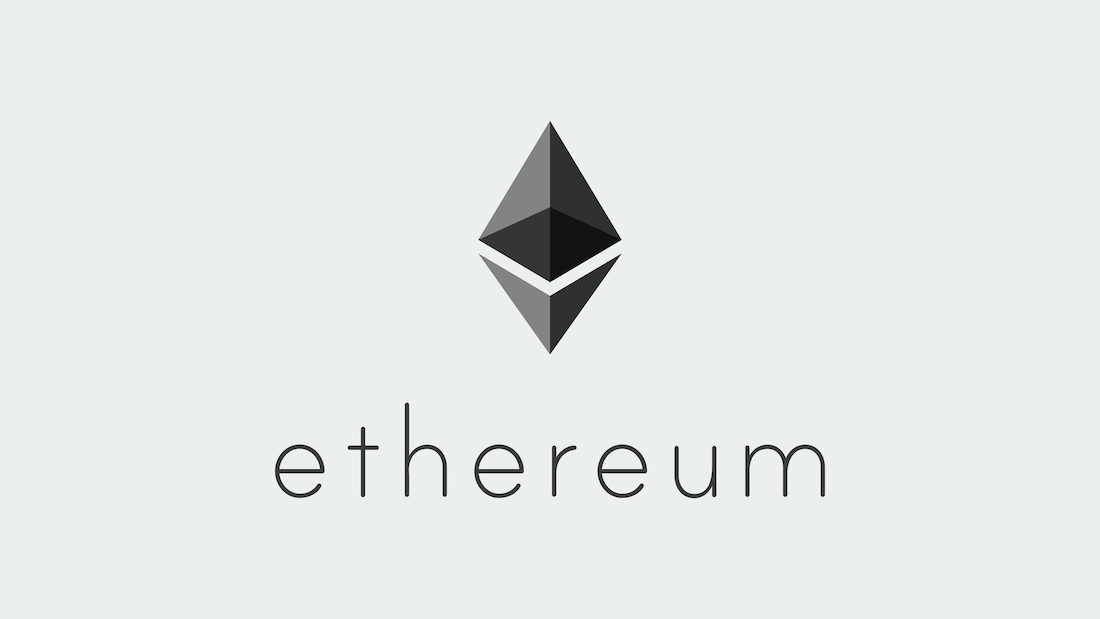

Cryptocurrencies have become one of the most discussed internet talking points in recent years. Twitter's CEO Jack Dorsey calls them "Internet money" and believes it will be with us forever. Elon Musk of Tesla tweets about Cryptocurrencies (especially "Dogecoin") almost every week. As of January 2022, there are more than 6000 cryptocurrencies in the market - an extreme growth from just a handful of digital coins in 2013.
It is believed that the top 20 cryptocurrencies make up nearly 90 percent of the total market. Ethereum or ETH is one of them. While ETH price increased exponentially since its creation, daily or even hourly fluctuation is part of the game. Some people get rich, and some people get broke. While various factors can influence the ETH price on the market, Ethereum price forecasting can be seen as a time-series problem. In this project, I will try to deploy different machine learning models to predict ETH price and validate it on recent data.

#**1 Data Loading**

##**Retrieving the Data**


You can download the original dataset from [here](https://raw.githubusercontent.com/MoMkhani/ETH-USD-PriceForecasting/main/Data/Binance_ETHUSDT_1h.csv). The data is obtained from the historical part of [cryptodatadownload.com](https://www.cryptodatadownload.com/data/apac/) which, provides crypto prices on different exchanges. I decided to retrieve eth price from the "ASIA & PACIFIC RIM EXCHANGES" section which, offers binance data.

The original dataset suffers from different problems which, I address in the next chapter. Finally, the cleaned version of our dataset is available on my [Github](https://raw.githubusercontent.com/MoMkhani/ETH-USD-PriceForecasting/main/Data/Cleaned-ETH%20dataset.csv).

##**1.1 Loading Libraries**

In [24]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.metrics import  mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm

# Models
import xgboost
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu

plt.style.use('classic')

##**1.2 Loading Dataset**

In [25]:
# Load dataset from github
url = 'https://raw.githubusercontent.com/NeedlerOP/Binance-Hrly/refs/heads/main/Binance_ETHUSDT_1h.csv'
df = pd.read_csv(url)
# Last five rows



# Method 1: Using pd.Series directly
#data = [1771200000000, 2695.2, 2697.94, 2690.0, 2693.04,4286.4822,11549670.347251,41200 ]  # Your desired values
#index = ['Unix', 'Open', 'High', 'Low', 'Close', 'Volume ETH','Volume USDT','trade count']  # Optional index labels
#new_row_data = pd.Series(data, index=index, name='MyArray')  # Create the Series


#new_row_data_transpose = new_row_data.transpose()

#new_row_data_transpose

#new_index = df.index[-1]

#new_row = pd.DataFrame([new_row_data], new_index)

#print(new_row)

#df = eth = pd.concat([df, new_row])

df.head()

<ipython-input-25-ff38e3e94172>:3: DtypeWarning: Columns (0,3,4,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


,,,,,,,,,https://www.CryptoDataDownload.com
Unix,Date,Symbol,Open,High,Low,Close,Volume ETH,Volume USDT,tradecount
1739660400000,2025-02-15 23:00:00,ETHUSDT,2695.2,2697.94,2690.0,2693.04,4286.4822,11549670.347251,41200
1739656800000,2025-02-15 22:00:00,ETHUSDT,2701.09,2704.0,2687.61,2695.19,5686.3776,15334450.105088,39427
1739653200000,2025-02-15 21:00:00,ETHUSDT,2686.1,2702.52,2685.8,2701.08,6190.2146,16680534.871184,53153
1739649600000,2025-02-15 20:00:00,ETHUSDT,2691.6,2697.0,2679.16,2686.11,7481.7791,20102924.165606,57721


In [11]:
df.tail()

,,,,,,,,,https://www.CryptoDataDownload.com
1502956800000,2017-08-17 08:00:00,ETHUSDT,307.95,309.97,307.0,308.62,150.75029,46559.462371,182
1502953200000,2017-08-17 07:00:00,ETHUSDT,302.68,307.96,302.6,307.96,754.7451,229725.136967,198
1502949600000,2017-08-17 06:00:00,ETHUSDT,302.4,304.44,301.9,302.68,303.86672,92034.441294,182
1502946000000,2017-08-17 05:00:00,ETHUSDT,301.61,303.28,300.0,303.1,377.67246,114043.282676,202
1502942400000,2017-08-17 04:00:00,ETHUSDT,301.13,302.57,298.0,301.61,125.66877,37684.804181,129


In [12]:
# Check the columns
df.columns

Index(['https://www.CryptoDataDownload.com'], dtype='object')

In [13]:
# Check the shape
df.shape

(65643, 1)

As we saw above, the original dataset is not comprehensively tidy. The header contains the website address that we should avoid. Also, unix and date columns have different formats which, prevents us from converting them as a DateTime object.

#**2 Analysis Plan**

This project is about generating different machine learning models to predict ethereum prices in the future. Considering one feature price to predict over time makes our issue a **univariate time series problem**. This is basically a **supervised machine learning problem**, assuming the dataset whereas a window of the last records as a feature to predict the next one as the target variable.

Because of its execution speed and model performance, **XGBoost** appears to be one of the most reasonable choices of the model. Since I don't have any feedback from the domain experts, maybe we can consider this model as our baseline.
Employing **LSTM**, time series forecasting models can predict future values based on previous, sequential data. This normally provides better accuracy for predictors which, results in better decision-making for the business.  Convolutional Neural Networks (**CNN**) are cheaper than LSTM since they learn by batch. Historically, CNNs are highly noise-resistant models that can catch very informative and non-time dependent features which lead to good performance. That's why I decided to deploy the CNN model on our data.

Here's the plan of analysis to implement this approach:


*   **Cleaning and preparing** to get the most out of our data.
*   **Exploratory Data Analysis (EDA)** to visualize observations through time, trends, and seasonality.
*   Conducting **statistical tests** to inspect stationarity.
*   **Creating a suitable dataset** that can be used for time series forecasting as a supervised machined learning problem.
*   **Defining an evaluation function** with different metrics.
*   Deploying **XGBoost, LSTM, and, CNN** models and monitoring the performance.
*   **Testing our best-trained model** on unseen and recent data.
*   **Ranking our models** based on performance metrics.



#**3 Data Preprocessing**

##**3.1 Data Formatting**

The date column clearly has diverse formats that prevent us to convert it to a data-time object. I extract rows with this characteristic based on string length. I would also make another segment for rows that follow the standard date format in our case. Using the strptime() method, I make a uniform format out of non-standard dates and concatenate two dataframes into one definitive dataframe.
Finally, before getting into our analysis, I drop unix, symbol, and tradecount columns that are unnecessary.

In [26]:
# Load again ignoring the first row (website domain)
df = pd.read_csv(url, header=1)
df.tail()

,Unix,Date,Symbol,Open,High,Low,Close,Volume ETH,Volume USDT,tradecount
65637,1502956800000,2017-08-17 08:00:00,ETHUSDT,307.95,309.97,307.0,308.62,150.75029,46559.462371,182
65638,1502953200000,2017-08-17 07:00:00,ETHUSDT,302.68,307.96,302.6,307.96,754.74510,229725.136967,198
65639,1502949600000,2017-08-17 06:00:00,ETHUSDT,302.40,304.44,301.9,302.68,303.86672,92034.441294,182
65640,1502946000000,2017-08-17 05:00:00,ETHUSDT,301.61,303.28,300.0,303.10,377.67246,114043.282676,202
65641,1502942400000,2017-08-17 04:00:00,ETHUSDT,301.13,302.57,298.0,301.61,125.66877,37684.804181,129


In [27]:
# Check columns
df.columns

Index(['Unix', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume ETH',
       'Volume USDT', 'tradecount'],
      dtype='object')

In [28]:
# Check shape
df.shape

(65642, 10)

In [29]:
# Extract rows that don't have standtad format
df = df.rename(columns={'Date': 'date'})
df = df.rename(columns={'Unix': 'unix'})
df = df.rename(columns={'Symbol': 'symbol'})
df = df.rename(columns={'Open': 'open'})
df = df.rename(columns={'High': 'high'})
df = df.rename(columns={'Low': 'low'})
df = df.rename(columns={'Close': 'close'})
df = df.rename(columns={'Volume ETH': 'volume ETH'})
df = df.rename(columns={'Volume USDT': 'volume USDT'})
df = df.rename(columns={'Tradecount': 'tradecount'})
nan_data = df[df['date'].str.len() !=19]
nan_data.shape

nan_data



,unix,date,symbol,open,high,low,close,volume ETH,volume USDT,tradecount
60982,1519858800000,2018-02-28 23:00:00.000,ETHUSDT,858.80,861.36,850.30,853.50,2688.93918,2.298593e+06,5220
60983,1519855200000,2018-02-28 22:00:00.000,ETHUSDT,863.54,865.50,858.34,858.35,1521.66768,1.311030e+06,3149
60984,1519851600000,2018-02-28 21:00:00.000,ETHUSDT,872.02,875.00,862.50,864.39,1410.23891,1.226549e+06,3617
60985,1519848000000,2018-02-28 20:00:00.000,ETHUSDT,869.60,874.99,868.70,872.51,1599.48261,1.395808e+06,3899
60986,1519844400000,2018-02-28 19:00:00.000,ETHUSDT,866.00,870.00,865.31,869.60,835.92342,7.254132e+05,2519
...,...,...,...,...,...,...,...,...,...,...
61617,1517457600000,2018-02-01 04:00:00.000,ETHUSDT,1140.00,1154.72,1130.18,1152.51,3899.48396,4.461803e+06,8404
61618,1517454000000,2018-02-01 03:00:00.000,ETHUSDT,1150.51,1164.99,1125.01,1140.00,7622.31840,8.731269e+06,12304
61619,1517450400000,2018-02-01 02:00:00.000,ETHUSDT,1134.07,1154.99,1134.07,1150.50,4828.74525,5.531565e+06,7307
61620,1517446800000,2018-02-01 01:00:00.000,ETHUSDT,1132.00,1140.89,1125.01,1135.00,4149.14991,4.703857e+06,7163


In [30]:
nan_data_save = nan_data

In [734]:
nan_data = nan_data_save

In [19]:

nan_data

nan_data.tail()

,unix,date,symbol,open,high,low,close,volume ETH,volume USDT,tradecount
61617,1517457600000,2018-02-01 04:00:00.000,ETHUSDT,1140.00,1154.72,1130.18,1152.51,3899.48396,4.461803e+06,8404
61618,1517454000000,2018-02-01 03:00:00.000,ETHUSDT,1150.51,1164.99,1125.01,1140.00,7622.31840,8.731269e+06,12304
61619,1517450400000,2018-02-01 02:00:00.000,ETHUSDT,1134.07,1154.99,1134.07,1150.50,4828.74525,5.531565e+06,7307
61620,1517446800000,2018-02-01 01:00:00.000,ETHUSDT,1132.00,1140.89,1125.01,1135.00,4149.14991,4.703857e+06,7163
61621,1517443200000,2018-02-01 00:00:00.000,ETHUSDT,1125.96,1137.99,1120.56,1132.00,3465.84651,3.915912e+06,7057


In [20]:
# Check if we catch them right!


import pandas as pd

#nan_data['date'] = nan_data['date'].astype(str)  # Convert to string type
#nan_data['date'] = nan_data['date'].str.replace(r'\.000$', '', regex=True)  # Remove trailing ".000"
#nan_data['date'] = nan_data['date'].str.replace(r'\.800$', '', regex=True)  # Remove trailing ".000"
#nan_data['date'] = pd.to_datetime(nan_data['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce') # Explicitly specify the format and handle errors
#nan_data.set_index('date', inplace=True) # Set 'date' as index after converting to datetime

#nan_data




<ipython-input-20-44403ff4da41>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nan_data['date'] = nan_data['date'].str.replace(r'\.000$', '', regex=True)  # Remove trailing ".000"
<ipython-input-20-44403ff4da41>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nan_data['date'] = nan_data['date'].str.replace(r'\.800$', '', regex=True)  # Remove trailing ".000"
<ipython-input-20-44403ff4da41>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

,unix,date,symbol,open,high,low,close,volume ETH,volume USDT,tradecount
60982,1519858800000,2018-02-28 23:00:00,ETHUSDT,858.80,861.36,850.30,853.50,2688.93918,2.298593e+06,5220
60983,1519855200000,2018-02-28 22:00:00,ETHUSDT,863.54,865.50,858.34,858.35,1521.66768,1.311030e+06,3149
60984,1519851600000,2018-02-28 21:00:00,ETHUSDT,872.02,875.00,862.50,864.39,1410.23891,1.226549e+06,3617
60985,1519848000000,2018-02-28 20:00:00,ETHUSDT,869.60,874.99,868.70,872.51,1599.48261,1.395808e+06,3899
60986,1519844400000,2018-02-28 19:00:00,ETHUSDT,866.00,870.00,865.31,869.60,835.92342,7.254132e+05,2519
...,...,...,...,...,...,...,...,...,...,...
61617,1517457600000,2018-02-01 04:00:00,ETHUSDT,1140.00,1154.72,1130.18,1152.51,3899.48396,4.461803e+06,8404
61618,1517454000000,2018-02-01 03:00:00,ETHUSDT,1150.51,1164.99,1125.01,1140.00,7622.31840,8.731269e+06,12304
61619,1517450400000,2018-02-01 02:00:00,ETHUSDT,1134.07,1154.99,1134.07,1150.50,4828.74525,5.531565e+06,7307
61620,1517446800000,2018-02-01 01:00:00,ETHUSDT,1132.00,1140.89,1125.01,1135.00,4149.14991,4.703857e+06,7163


In [771]:
nan_data_save2 = nan_data

In [ ]:
nan_data = nan_data_save2

In [31]:
dfsave = df

In [ ]:
df = dfsave


In [32]:
# Extract rows from ETH were wrong

#dfcopy = df

df = df[df.date.str.len()== 19]
df.shape

(65002, 10)

In [742]:
# Concatenate two dfs to make a new one
eth = pd.concat([nan_data,eth_data], axis=0)
# Check if shape is right
eth.shape

(66282, 10)

In [743]:
eth

,unix,date,symbol,open,high,low,close,volume ETH,volume USDT,tradecount
60982,1519858800000,2018-02-28 23:00:00,ETHUSDT,858.80,861.36,850.30,853.50,2688.93918,2.298593e+06,5220
60983,1519855200000,2018-02-28 22:00:00,ETHUSDT,863.54,865.50,858.34,858.35,1521.66768,1.311030e+06,3149
60984,1519851600000,2018-02-28 21:00:00,ETHUSDT,872.02,875.00,862.50,864.39,1410.23891,1.226549e+06,3617
60985,1519848000000,2018-02-28 20:00:00,ETHUSDT,869.60,874.99,868.70,872.51,1599.48261,1.395808e+06,3899
60986,1519844400000,2018-02-28 19:00:00,ETHUSDT,866.00,870.00,865.31,869.60,835.92342,7.254132e+05,2519
...,...,...,...,...,...,...,...,...,...,...
65637,1502956800000,2017-08-17 08:00:00,ETHUSDT,307.95,309.97,307.00,308.62,150.75029,4.655946e+04,182
65638,1502953200000,2017-08-17 07:00:00,ETHUSDT,302.68,307.96,302.60,307.96,754.74510,2.297251e+05,198
65639,1502949600000,2017-08-17 06:00:00,ETHUSDT,302.40,304.44,301.90,302.68,303.86672,9.203444e+04,182
65640,1502946000000,2017-08-17 05:00:00,ETHUSDT,301.61,303.28,300.00,303.10,377.67246,1.140433e+05,202


In [33]:


#data = [1771200000000, 2695.2, 2697.94, 2690.0, 2693.04,4286.4822,11549670.347251,41200 ]  # Your desired values


df.loc['1'] = [1771200000000,'2026-02-15 00:00:00',0,0,0,0,0,0,0,0]



#datenew= {'date':pd.to_datetime(['2026-02-15 00:00:00'])}
#nan_data.loc['1'] = [1771200000000, datenew,0,0,0,0,0,0,0,0]
#nan_data = pd.DataFrame(nan_data)

#nan_data['date'] = nan_data['date'].dt.strftime('%Y-%m-%d %I-%p')


#data = [1771200000000, 2695.2, 2697.94, 2690.0, 2693.04,4286.4822,11549670.347251,41200 ]  # Your desired values

# Convert 'date' column to datetime objects if it's not already
nan_data['date'] = pd.to_datetime(nan_data['date'])

# Now apply strftime
nan_data.loc['1'] = [1771200000000, '2026-02-15 00:00:00',0,0,0,0,0,0,0,0] # Assign a string representation of the date
nan_data['date'] = pd.to_datetime(nan_data['date']) # Convert the 'date' column to datetime
nan_data['date'] = nan_data['date'].dt.strftime('%Y-%m-%d %I-%p') # Apply strftime


nan_data.head()

<ipython-input-33-b6847e1e1f58>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nan_data.loc['1'] = [1771200000000,'2026-02-15 00:00:00',0,0,0,0,0,0,0,0]


ValueError: time data "2026-02-15 00:00:00" doesn't match format "%Y-%m-%d %H:%M:%S.%f", at position 640. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [626]:
# Format with standard practice
# Convert 'date' column back to datetime objects before applying strftime
nan_data['date'] = pd.to_datetime(nan_data['date'], format='%Y-%m-%d %I:%M:%S %p')  # Explicitly specify the format including seconds and space before AM/PM
nan_data['date'] = nan_data['date'].dt.strftime('%Y-%m-%d %I:%M:%S') # Apply strftime for output
nan_data.head(10)

,unix,date,symbol,open,high,low,close,volume ETH,volume USDT,tradecount
1,1771200000000,2026-02-15 12:00:00,0,0,0,0,0,0,0,0


In [627]:
# Concatenate two dfs to make a new one
eth = pd.concat([nan_data,eth_data], axis=0)
# Check if shape is right
eth.shape


(65643, 10)

In [628]:
# Check if df is fine
eth.head(3)

,unix,date,symbol,open,high,low,close,volume ETH,volume USDT,tradecount
1,1771200000000,2026-02-15 12:00:00,0,0.00,0.00,0.00,0.00,0.0000,0.000000e+00,0
0,1739660400000,2025-02-15 23:00:00,ETHUSDT,2695.20,2697.94,2690.00,2693.04,4286.4822,1.154967e+07,41200
1,1739656800000,2025-02-15 22:00:00,ETHUSDT,2701.09,2704.00,2687.61,2695.19,5686.3776,1.533445e+07,39427


In [630]:
eth.to_csv('eth.csv')

ethsave = eth

In [631]:

# Retrieve eth from eth.csv without setting index
eth = pd.read_csv('eth.csv')

# Convert 'date' column to datetime
eth['date'] = pd.to_datetime(eth['date'])

# Display the DataFrame
eth.head()
# Display the DataFrame
eth.head()

ValueError: unconverted data remains when parsing with format "%Y-%m-%d %H:%M:%S": ".000", at position 60983. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [585]:

#Convert date column to datatime object
#eth['date'] = pd.to_datetime(eth.date)
#eth.set_index('date', inplace=True)


#TAKEN TRAILINGS .000 earlier

#eth['date'] = eth['date'].astype(str)  # Convert to string type
#eth['date'] = eth['date'].str.replace(r'\.000$', '', regex=True)  # Remove trailing ".000"
#eth['date'] = pd.to_datetime(eth['date'], format='%Y-%m-%d %I:%M:%S %p', errors='coerce') # Explicitly specify the format and handle errors
#eth.set_index('date', inplace=True) # Set 'date' as index after converting to datetime

# Drop unix column
eth.drop(columns=['unix','Unnamed: 0',	'symbol', 'tradecount'], inplace=True)
eth.sort_index(ascending=True, inplace=True)
eth.tail()

KeyError: 'date'

##**3.2 Handling Missing Values**

Scanning for any missing values, I found out there is still one row without a value in the "Volume USDT" column. I decided to take an average of two records before and after our missing one to fill in the data.

In [540]:
# Check if there is any nan
eth.isnull().sum()

,0
open,0
high,0
low,0
close,0
volume ETH,0
volume USDT,0


In [541]:
# Find rows that are missing
nan = eth[eth.isnull().any(axis=1)]
nan

,open,high,low,close,volume ETH,volume USDT
date,,,,,,


In [543]:
# Select rows before and after our target row
rows_toavg = eth.loc[['2019-11-07 02:00:00','2019-11-07 04:00:00'], 'volume USDT']
rows_toavg

rows_toavg = eth.loc[['2025-02-15 23:00:00','2026-02-15 00:00:00'], 'date']
rows_toavg



KeyError: 'date'

In [81]:
# Take average of two rows to fill in our missing record
eth.fillna(rows_toavg.mean(), inplace=True)

In [82]:
# Check if there is still any nan
eth.isnull().sum()

,0
open,0
high,0
low,0
close,0
Volume ETH,0
Volume USDT,0


In [83]:
# How it looks now
eth.loc['2019-11-07 02:00:00':'2019-11-07 05:00:00']

,open,high,low,close,Volume ETH,Volume USDT
date,,,,,,
2019-11-07 02:00:00,189.70,189.82,188.39,189.41,19920.40770,3.766850e+06
2019-11-07 03:00:00,189.41,189.82,188.81,189.43,8398.71214,1.590046e+06
2019-11-07 04:00:00,189.44,189.76,189.00,189.05,9414.96569,1.782677e+06
2019-11-07 05:00:00,189.08,189.78,187.19,189.68,26232.51838,4.943418e+06


#**4 Data Description and Exploration**

##**4.1 Data Information**

In [84]:
# Basic info
eth.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65550 entries, 2017-08-17 04:00:00 to 2025-02-11 23:00:00
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open         65550 non-null  float64
 1   high         65550 non-null  float64
 2   low          65550 non-null  float64
 3   close        65550 non-null  float64
 4   Volume ETH   65550 non-null  float64
 5   Volume USDT  65550 non-null  float64
dtypes: float64(6)
memory usage: 5.5 MB


##**4.2 Summary Statistics**

In [98]:
# Summary stats
eth.describe()

,open,high,low,close,Volume ETH,Volume USDT,close_log
count,65550.000000,65550.000000,65550.000000,65550.000000,65550.000000,6.555000e+04,65550.000000
mean,1480.932914,1489.371564,1471.870975,1480.963573,21941.287547,3.320995e+07,6.778890
std,1234.691487,1241.169029,1227.682079,1234.690588,26530.391389,5.153683e+07,1.151396
min,82.160000,82.950000,81.790000,82.170000,0.000000,0.000000e+00,4.420887
25%,281.142500,283.812500,278.932500,281.000000,7122.471275,3.239562e+06,5.641907
50%,1323.050000,1329.845000,1314.375000,1323.045000,13983.937755,1.518366e+07,7.188447
75%,2434.797500,2449.430000,2418.647500,2434.837500,26991.480925,4.368802e+07,7.798046
max,4846.940000,4868.000000,4833.190000,4846.710000,508838.404900,1.245779e+09,8.486262


##**4.3 Data Visualization**

In [111]:
# Resample data based on time periods to have clear view
eth_month = eth.resample('M').median()
eth_week = eth.resample('W').median()
eth_daily = eth.resample('D').median()

<ipython-input-111-2b20a280b2a5>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  eth_month = eth.resample('M').median()


###**4.3.1 ETH Price through Time**

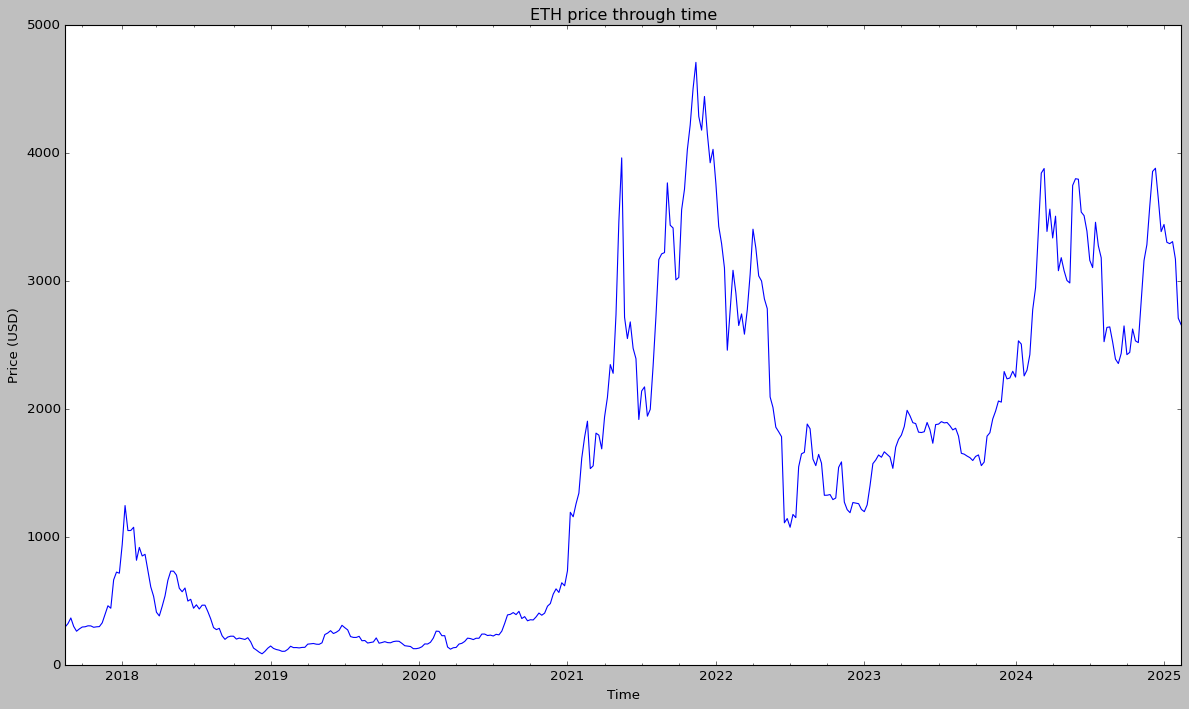

In [112]:
# Plot closing price through time
eth_week.close.plot(title='ETH price through time',
                                      xlabel='Time', ylabel='Price (USD)', figsize=[18,10])
plt.show()

ETH price has increased exponentially since 2017, first got peaked in the first weeks of 2018. Since then the price fluctuated between 100 and 500 usd until the last months of 2020. ETh started 2021 above 1000 usd and soon passed 2000 and 3000 usd values.

###**4.3.2 ETH Volume through Time**

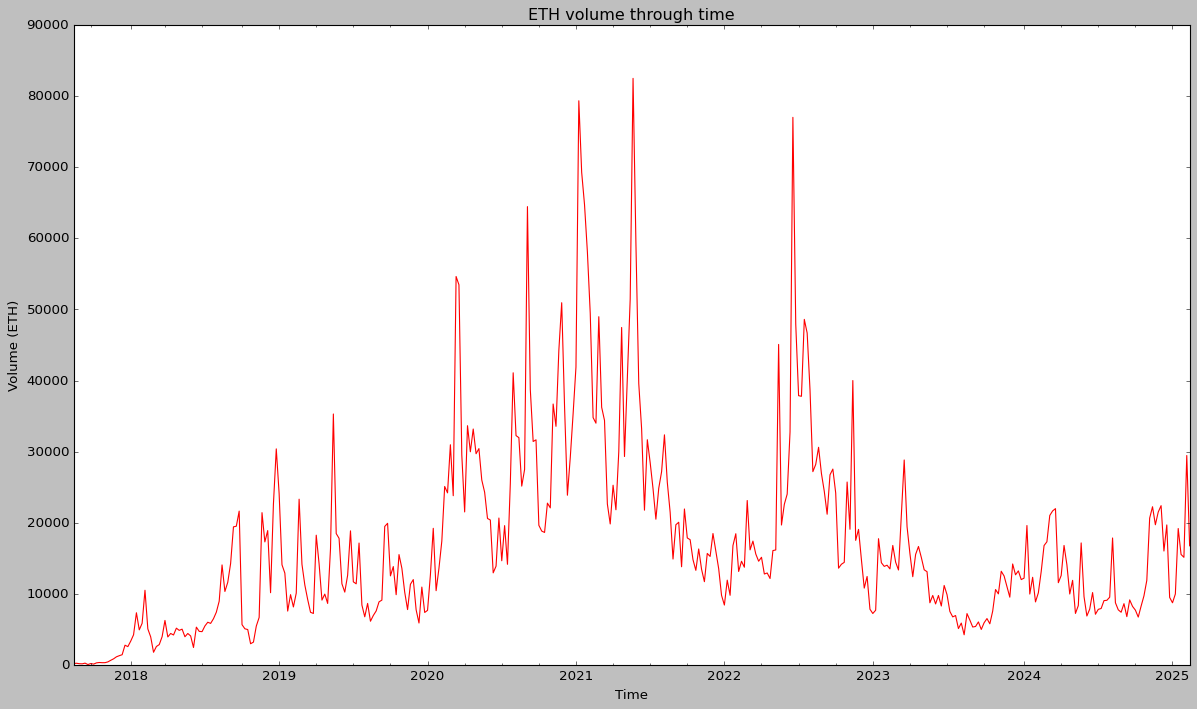

In [113]:
# Plot volume through time
eth_week['Volume ETH'].plot(title='ETH volume through time',
                                      xlabel='Time', ylabel='Volume (ETH)', color='red', figsize=[18,10])
plt.show()

###**4.3.3 Closing ETH Price in 2021 by Day, Month and Year**

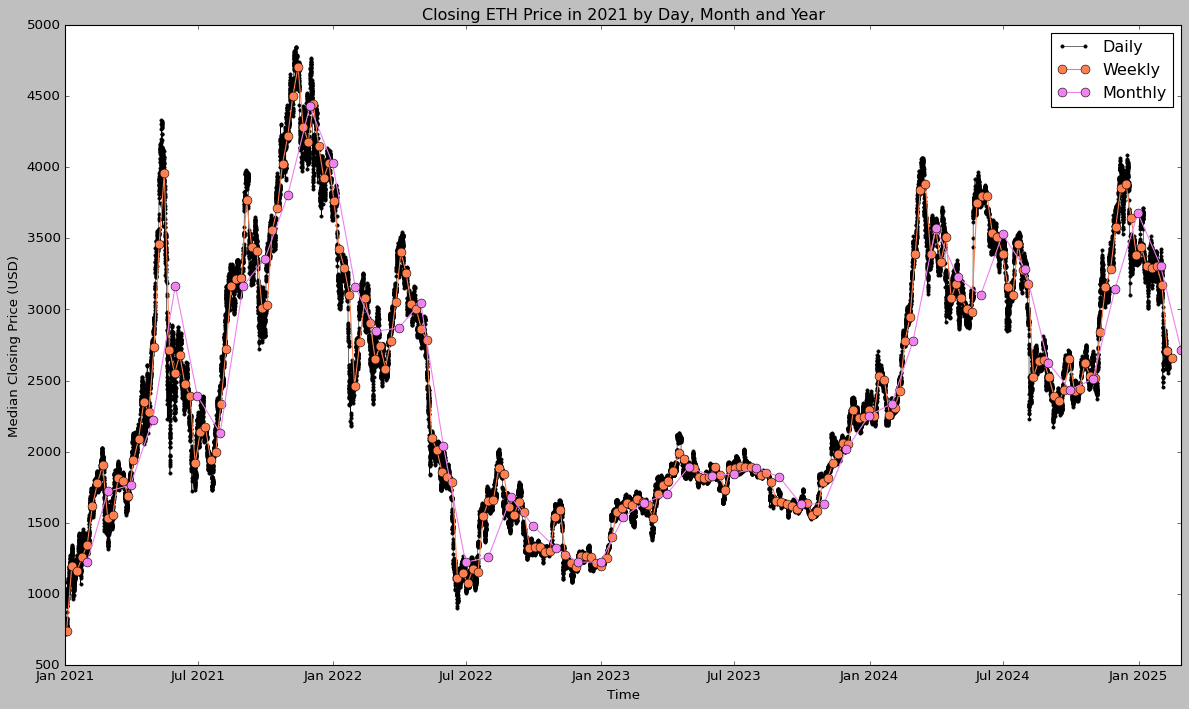

In [115]:
# Set dates as 2021
start, end = '2021-01', '2025-02'
# Plot three frequencies (daily, weekly, and monthly basis)
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(eth.loc[start:end, 'close'], marker='.', linestyle='-', linewidth = 0.5, label='Daily', color='black')
ax.plot(eth_week.loc[start:end, 'close'], marker='o', markersize=8, linestyle='-', label='Weekly', color='coral')
ax.plot(eth_month.loc[start:end, 'close'], marker='o', markersize=8, linestyle='-', label='Monthly', color='violet')
ax.set_title('Closing ETH Price in 2021 by Day, Month and Year')
ax.set_xlabel('Time')
ax.set_ylabel('Median Closing Price (USD)')
ax.legend()

###**4.3.4 ETH Opening Price Heatmap**

In [116]:
import calendar
# Create pivot table of eth opening price
all_month_year_df = pd.pivot_table(eth, values="open",
                                   index=eth.index.month,
                                   columns=eth.index.year
)
named_index = [[calendar.month_abbr[i] if isinstance(i, int) else i for i in list(all_month_year_df.index)]] # name months
all_month_year_df = all_month_year_df.set_index(named_index)
all_month_year_df

date,2017,2018,2019,2020,2021,2022,2023,2024,2025
Jan,NaN,1083.501763,126.477634,155.238616,1187.572097,3062.769368,1459.284220,2373.225121,3331.760242
Feb,NaN,876.836234,125.860461,237.573275,1693.455097,2860.431384,1624.886205,2724.742572,2775.722195
Mar,NaN,630.080161,136.005650,161.898748,1722.294253,2873.046371,1669.859367,3624.828172,NaN
Apr,NaN,515.853083,164.736833,170.136908,2272.364601,3108.776319,1916.953069,3256.258625,NaN
May,NaN,677.712944,217.741199,206.978306,3145.557097,2205.307124,1841.911075,3291.880833,NaN
Jun,NaN,521.087616,273.942056,235.707950,2334.940778,1389.725403,1817.868556,3572.151889,NaN
Jul,NaN,462.208304,248.387312,256.679220,2121.645323,1342.992970,1895.406734,3274.228199,NaN
Aug,327.681938,323.042218,200.068315,399.326680,3077.480216,1705.830497,1760.764852,2655.615739,NaN
Sep,294.285947,227.114958,184.922528,369.084944,3347.006379,1488.143417,1621.783056,2463.237056,NaN
Oct,305.518669,211.984453,177.971680,375.485968,3796.526505,1364.313683,1656.529368,2526.806841,NaN


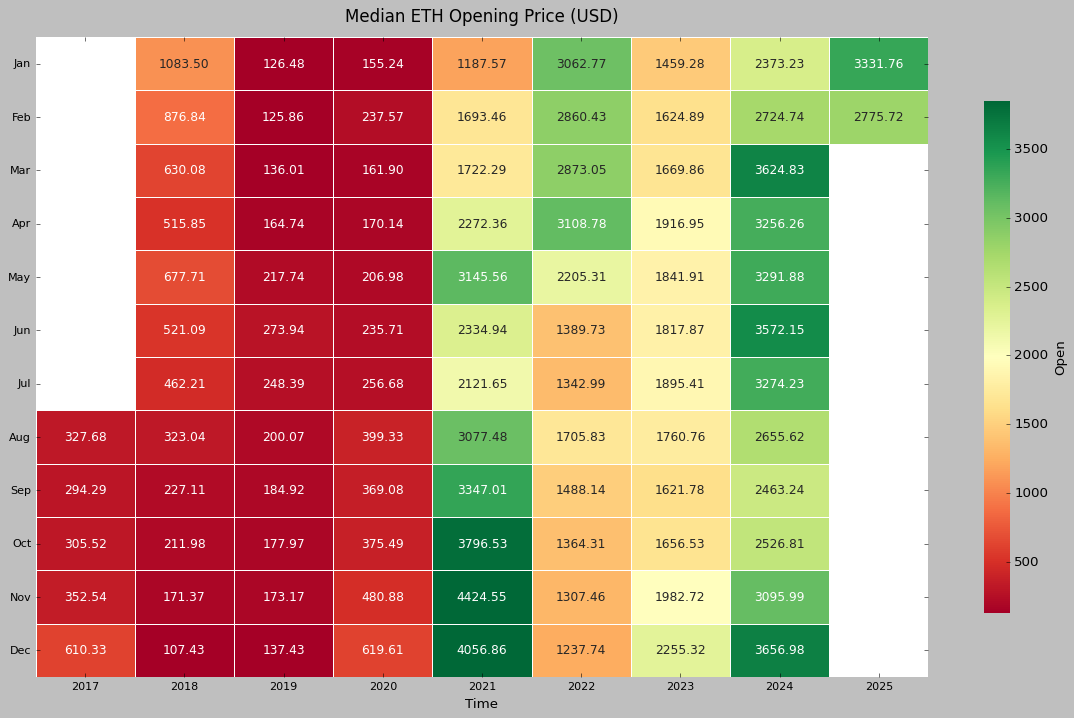

In [104]:
plt.figure(figsize=[18,10])
# Plot the heatmap
ax = sns.heatmap(all_month_year_df, cmap='RdYlGn', robust=True, fmt='.2f',
                 annot=True, linewidths=.5, annot_kws={'size':11},
                 cbar_kws={'shrink':.8, 'label':'Open'})

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.title('Median ETH Opening Price (USD)', fontdict={'fontsize':15},    pad=14)
plt.xlabel('Time')
plt.show()

###**4.3.5 Plotting the Change**

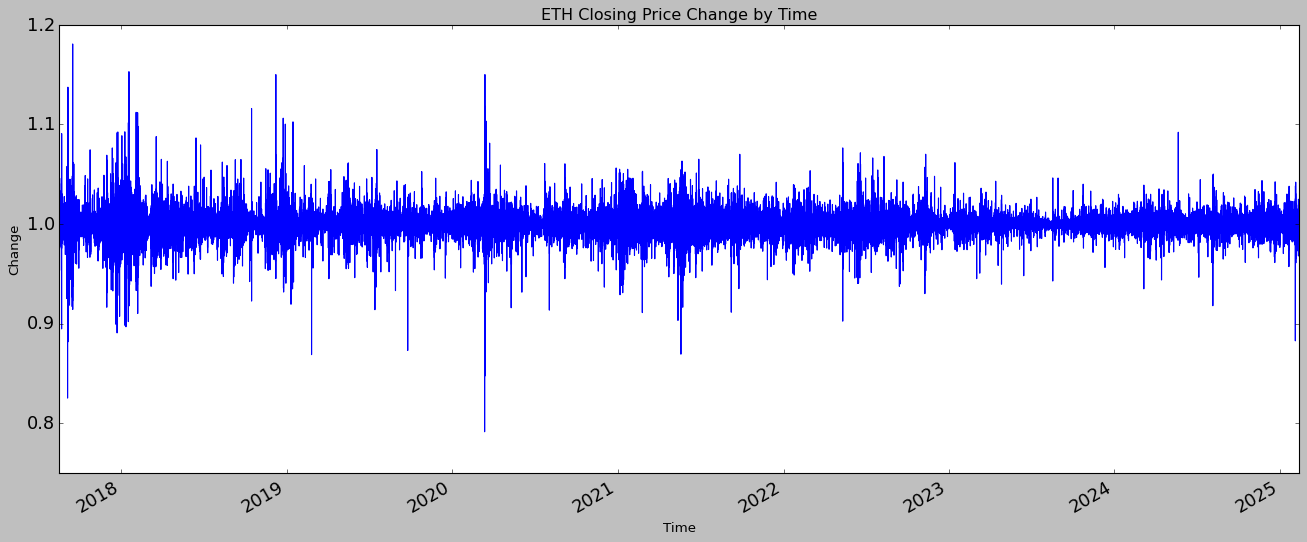

In [117]:
# Make copy of original eth dataset
vis_df = eth.copy()
# Adding change column in new dateset using shift
vis_df['change'] = vis_df.close.div(vis_df.close.shift())
# Plotting the change
vis_df['change'].plot(figsize=(20, 8), fontsize = 16)
plt.xlabel('Time')
plt.ylabel('Change')
plt.title('ETH Closing Price Change by Time')
plt.show()

###**4.3.6 Plotting the Percentage Change**

In [118]:
# Resample new viz dataset by month
vis_month = vis_df.resample('M').median()
# Calculate percentage change in new column
vis_month['pct_change'] = vis_month.close.pct_change()*100

<ipython-input-118-2962da963df1>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  vis_month = vis_df.resample('M').median()


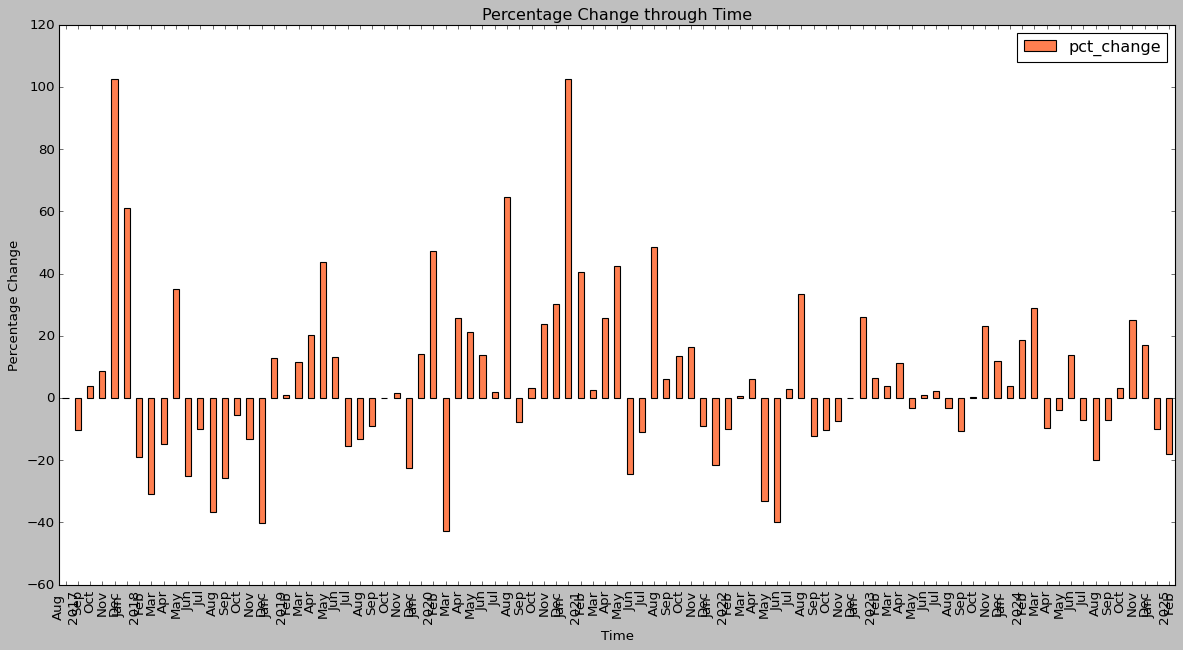

In [119]:
fig, ax = plt.subplots(figsize=(18, 10))
# Plot percentage change
vis_month['pct_change'].plot(kind='bar', color='coral', ax=ax)
# Set major ticks and tick labels
ax.set_xticks(range(vis_month.index.size))
ax.set_xticklabels([ts.strftime('%b\n%Y') if ts.year != vis_month.index[idx-1].year
                    else ts.strftime('%b') for idx, ts in enumerate(vis_month.index)])
ax.figure.autofmt_xdate(rotation=0, ha='center');
ax.set(xlabel='Time',
       ylabel='Percentage Change',
       title='Percentage Change through Time')
plt.xticks(rotation=90)
ax.legend()

###**4.3.7 Plotting the Decomposition**

<Figure size 1440x800 with 0 Axes>

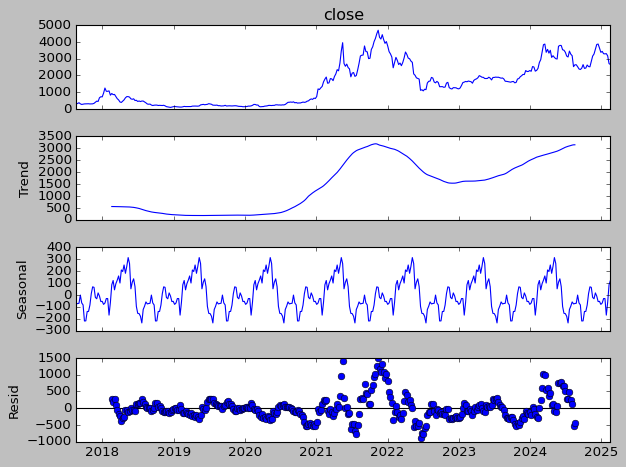

In [120]:
# Plot decomposition using statsmodel api
plt.figure(figsize=[18,10])
sm.tsa.seasonal_decompose(eth.resample("W").median().close).plot()
plt.show()

In [121]:
# Add log to closing price
eth["close_log"] = np.log1p(eth.close)
eth.head()

,open,high,low,close,Volume ETH,Volume USDT,close_log
date,,,,,,,
2017-08-17 04:00:00,301.13,302.57,298.0,301.61,125.66877,37684.804181,5.712445
2017-08-17 05:00:00,301.61,303.28,300.0,303.10,377.67246,114043.282676,5.717357
2017-08-17 06:00:00,302.40,304.44,301.9,302.68,303.86672,92034.441294,5.715975
2017-08-17 07:00:00,302.68,307.96,302.6,307.96,754.74510,229725.136967,5.733212
2017-08-17 08:00:00,307.95,309.97,307.0,308.62,150.75029,46559.462371,5.735346


<Figure size 1440x800 with 0 Axes>

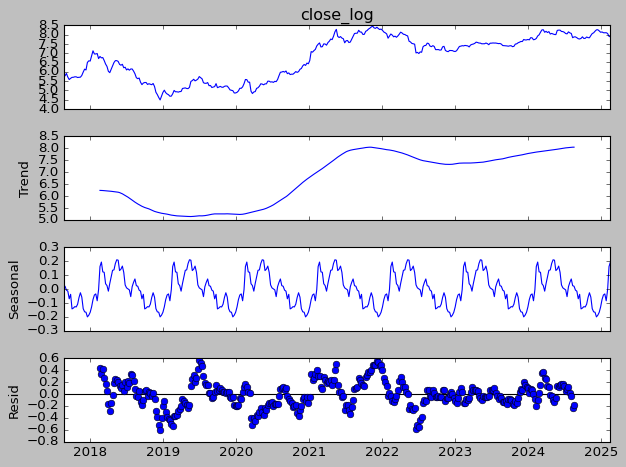

In [122]:
plt.figure(figsize=[18,10])
sm.tsa.seasonal_decompose(eth.resample("W").median().close_log).plot()
plt.show()

#**5 Statistical Tests**

## **5.1 Dickey-Fuller-Test**

In [125]:
dickey = sm.tsa.stattools.adfuller(eth.resample("W").mean().close)

print(f'ADF Statistic: {dickey[0]:.2f}')
print(f'p-value: {dickey[1]:.2f}')
print('Critical Values:')
for key, value in dickey[4].items():
        print(f'\t {key}: {value:.3f}')

ADF Statistic: -1.45
p-value: 0.56
Critical Values:
	 1%: -3.448
	 5%: -2.869
	 10%: -2.571


In [126]:
dickey = sm.tsa.stattools.adfuller(eth.resample("W").mean().close_log)

print(f'ADF Statistic: {dickey[0]:.2f}')
print(f'p-value: {dickey[1]:.2f}')
print('Critical Values:')
for key, value in dickey[4].items():
        print(f'\t {key}: {value:.3f}')

ADF Statistic: -1.16
p-value: 0.69
Critical Values:
	 1%: -3.447
	 5%: -2.869
	 10%: -2.571


# **6. Feature Engineering**

In [127]:
# Create main set to train and validate
# eth_main = eth.loc['2017-08-17':]
eth_main = eth.loc['2017-08-17':'2021-10-15']
eth_main.shape

(36374, 7)

In [128]:
eth_main.tail()

,open,high,low,close,Volume ETH,Volume USDT,close_log
date,,,,,,,
2021-10-15 19:00:00,3879.97,3882.99,3836.10,3848.90,14561.6656,5.614232e+07,8.255802
2021-10-15 20:00:00,3848.91,3907.77,3833.00,3881.36,35909.0981,1.391489e+08,8.264198
2021-10-15 21:00:00,3881.37,3884.63,3820.87,3841.40,14950.9961,5.766778e+07,8.253852
2021-10-15 22:00:00,3841.41,3857.73,3832.15,3849.76,12072.0272,4.640737e+07,8.256026
2021-10-15 23:00:00,3849.77,3874.00,3839.55,3868.99,12247.8107,4.723873e+07,8.261007


In [290]:
# Create holdout set
eth_recent = eth.loc['2025-02-12':]
eth_recent.shape

(0, 7)

In [130]:
eth_recent.tail()

,open,high,low,close,Volume ETH,Volume USDT,close_log
date,,,,,,,
2025-02-11 19:00:00,2610.78,2619.00,2580.00,2589.70,42370.1269,1.100090e+08,7.859683
2025-02-11 20:00:00,2589.69,2612.25,2585.51,2598.44,35959.3306,9.336598e+07,7.863051
2025-02-11 21:00:00,2598.32,2631.36,2592.15,2622.12,22647.9795,5.911869e+07,7.872120
2025-02-11 22:00:00,2622.11,2631.29,2558.24,2586.39,27062.9662,7.026157e+07,7.858405
2025-02-11 23:00:00,2586.40,2611.77,2584.84,2602.59,16252.8069,4.227265e+07,7.864647


In [293]:
# Preparing dataset
split = int(eth_main.shape[0]*0.8)
df_train = eth_main[:split]
df_test = eth_main[split:]
df_test.head()
#df_train.head()

,open,high,low,close,Volume ETH,Volume USDT,close_log
date,,,,,,,
2020-12-16 04:00:00,583.31,584.38,580.71,583.27,18373.97127,1.070692e+07,6.370363
2020-12-16 05:00:00,583.26,585.22,582.83,583.98,14330.21312,8.367912e+06,6.371578
2020-12-16 06:00:00,583.98,586.49,583.31,585.72,19108.60421,1.117768e+07,6.374548
2020-12-16 07:00:00,585.72,586.50,584.46,585.02,14636.26773,8.566497e+06,6.373354
2020-12-16 08:00:00,585.01,588.21,583.80,588.16,17856.25957,1.046289e+07,6.378698


In [132]:
# Write a function to generate desired dataset
def create_dataset(df, n, feature=-1):
   """Create proper dataset for supervised time series forcasting.

   Args:
   df: input dataframe
   n: number of values to consider in a window as features
   feature: chosen column (feature) to perform

   Return:
   x, y = returns x as features and y as target variable
   """
   x = []
   y = []

   for i in range(n, df.shape[0]):
     x.append(df[i-n:i, feature])
     y.append(df[i, feature])
   x = np.expand_dims(np.array(x), -1)
   y = np.expand_dims(np.array(y), -1)
   return x, y

In [133]:
# Scale before modeling
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(df_train)
dataset_train[0:5]

array([[1.62338288e-01, 1.61836336e-01, 1.64544631e-01, 1.62687939e-01,
        2.71402706e-04, 1.81403812e-04, 4.53823581e-01],
       [1.62694147e-01, 1.62359530e-01, 1.66066713e-01, 1.63792592e-01,
        8.15646780e-04, 5.48971572e-04, 4.55549455e-01],
       [1.63279831e-01, 1.63214325e-01, 1.67512690e-01, 1.63481213e-01,
        6.56250953e-04, 4.43027338e-04, 4.55063824e-01],
       [1.63487415e-01, 1.65808187e-01, 1.68045419e-01, 1.67395688e-01,
        1.62999815e-03, 1.10583076e-03, 4.61120613e-01],
       [1.67394447e-01, 1.67289341e-01, 1.71393998e-01, 1.67884997e-01,
        3.25570439e-04, 2.24123864e-04, 4.61870423e-01]])

In [134]:
# Scale validation set
dataset_test = scaler.transform(df_test)

In [135]:
# Create train and test sets using our function
X_train, y_train = create_dataset(dataset_train,50,-1)
X_test, y_test = create_dataset(dataset_test,50,-1)

In [346]:
# Check if it worked!
X_train.shape
X_train.tail()

,Date
163,163
164,164
165,165
166,166
167,167


In [287]:
# y_train.shape

y_train.head()

,Predictions
0,0
1,1
2,2
3,3
4,4


from matplotlib import pyplot as plt
_df_0['Predictions'].plot(kind='hist', bins=20, title='Predictions')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Predictions']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Predictions'}, axis=1)
              .sort_values('Predictions', ascending=True))
  xs = counted['Predictions']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('Predictions', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Predictions')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_2['Predictions'].plot(kind='line', figsize=(8, 4), title='Predictions')
plt.gca().spines[['top', 'right']].set_visible(False)

# **7. Evaluation Function**

In [ ]:
def evaluate_model(model, model_name="Model", test_data=X_test, target_data=y_test):
    """ Create an evaluation function and plot the result.
    Args:
        model: selected model that has been used
        model_name: label to plot
        test_data: validation set of features
        target_data: validation set of target

    Returns:
        test_rs: R-squared value of test set
        test_MAE: mean absolute error of test set

    """
    y_pred_test = model.predict(test_data)

    try:
        y_pred_test = y_pred_test.yhat
    except:
        pass

    test_rs = r2_score(target_data,y_pred_test)
    print('R Squared : ', round(test_rs,5))

    test_MAE = mean_absolute_error(target_data, y_pred_test)
    print('Mean Absolute Error: ', round(test_MAE, 5))

    plt.figure(figsize=(20,10))
    plt.plot(y_pred_test, color='green', marker='o', linestyle='dashed',label='Predicted Price')
    plt.plot(target_data, color='red', label='Actual Price')
    plt.title('Comparison of actual and predicted ETH-USD price for ' + model_name)
    plt.xlabel('Day')
    plt.ylabel('Prices')
    plt.legend()
    plt.show()

    return test_rs, test_MAE

# **8. Models**

## **8.1 XGBOOST**

In [139]:
# Instantiate an xgboost regressor object
xgb_model = xgboost.XGBRegressor()
# Fit the training date
xgb_model.fit(np.squeeze(X_train), np.squeeze(y_train))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

R Squared :  -1.17867
Mean Absolute Error:  0.18821


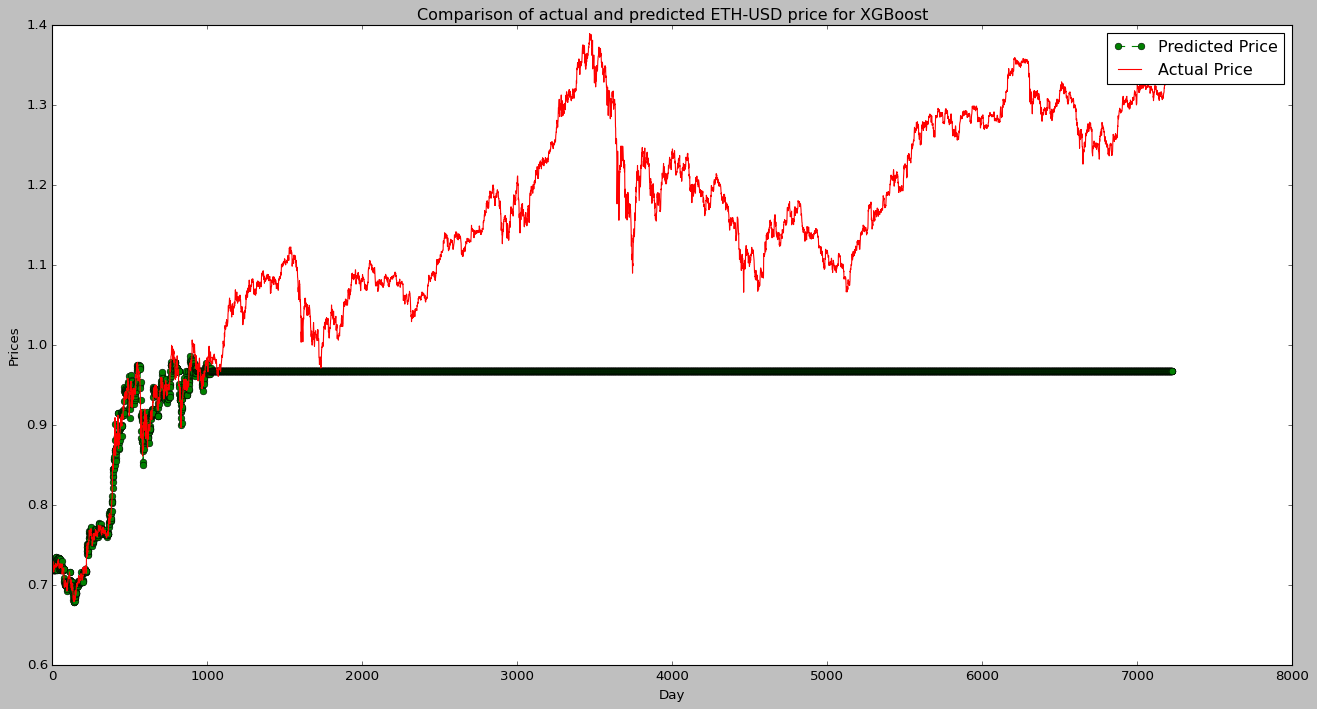

(-1.1786729311246131, 0.1882096836066798)

In [140]:
# Evaluate the results
evaluate_model(xgb_model, model_name="XGBoost", test_data=np.squeeze(X_test), target_data=np.squeeze(y_test))

## **8.2 LSTM**

In [141]:
# Instantiate sequential model
LSTM_Model = Sequential()

In [142]:
# Define lstm model
LSTM_Model.add(LSTM(units=96,
                    return_sequences=True,
                    input_shape=(X_train.shape[1], 1)))
LSTM_Model.add(Dropout(0.2))
LSTM_Model.add(LSTM(units=96,
                    return_sequences=True))
LSTM_Model.add(Dropout(0.2))
LSTM_Model.add(LSTM(units=96,
                    return_sequences=True))
LSTM_Model.add(Dropout(0.2))
LSTM_Model.add(LSTM(units=96))
LSTM_Model.add(Dropout(0.2))
LSTM_Model.add(Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [143]:
# Config the model
LSTM_Model.compile(loss=MSE, optimizer=Adam())

In [144]:
# Summary of model
LSTM_Model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 96)              │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 96)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50, 96)              │          74,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50, 96)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50, 96)              │          74,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50, 96)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 96)                  │          74,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              97 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 260,065 (1015.88 KB)

 Trainable params: 260,065 (1015.88 KB)

 Non-trainable params: 0 (0.00 B)

In [146]:
# Fit the model
LSTM_Model.fit(X_train,y_train,batch_size=32,epochs=10,verbose=1,validation_split=0.05)

Epoch 1/10
863/863 ━━━━━━━━━━━━━━━━━━━━ 145s 168ms/step - loss: 8.2109e-04 - val_loss: 5.8907e-05
Epoch 2/10
863/863 ━━━━━━━━━━━━━━━━━━━━ 201s 167ms/step - loss: 6.4190e-04 - val_loss: 1.7954e-04
Epoch 3/10
863/863 ━━━━━━━━━━━━━━━━━━━━ 202s 167ms/step - loss: 5.4035e-04 - val_loss: 1.6324e-04
Epoch 4/10
863/863 ━━━━━━━━━━━━━━━━━━━━ 149s 173ms/step - loss: 5.1758e-04 - val_loss: 5.1926e-05
Epoch 5/10
863/863 ━━━━━━━━━━━━━━━━━━━━ 153s 177ms/step - loss: 4.1440e-04 - val_loss: 2.9202e-05
Epoch 6/10
863/863 ━━━━━━━━━━━━━━━━━━━━ 195s 169ms/step - loss: 3.5427e-04 - val_loss: 3.7646e-05
Epoch 7/10
863/863 ━━━━━━━━━━━━━━━━━━━━ 202s 169ms/step - loss: 3.2472e-04 - val_loss: 4.6955e-04
Epoch 8/10
863/863 ━━━━━━━━━━━━━━━━━━━━ 145s 168ms/step - loss: 3.1429e-04 - val_loss: 3.9897e-05
Epoch 9/10
863/863 ━━━━━━━━━━━━━━━━━━━━ 202s 169ms/step - loss: 3.1835e-04 - val_loss: 2.1201e-04
Epoch 10/10
863/863 ━━━━━━━━━━━━━━━━━━━━ 203s 170ms/step - loss: 3.0010e-04 - val_loss: 3.4824e-05


226/226 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step
R Squared :  0.80234
Mean Absolute Error:  0.05618


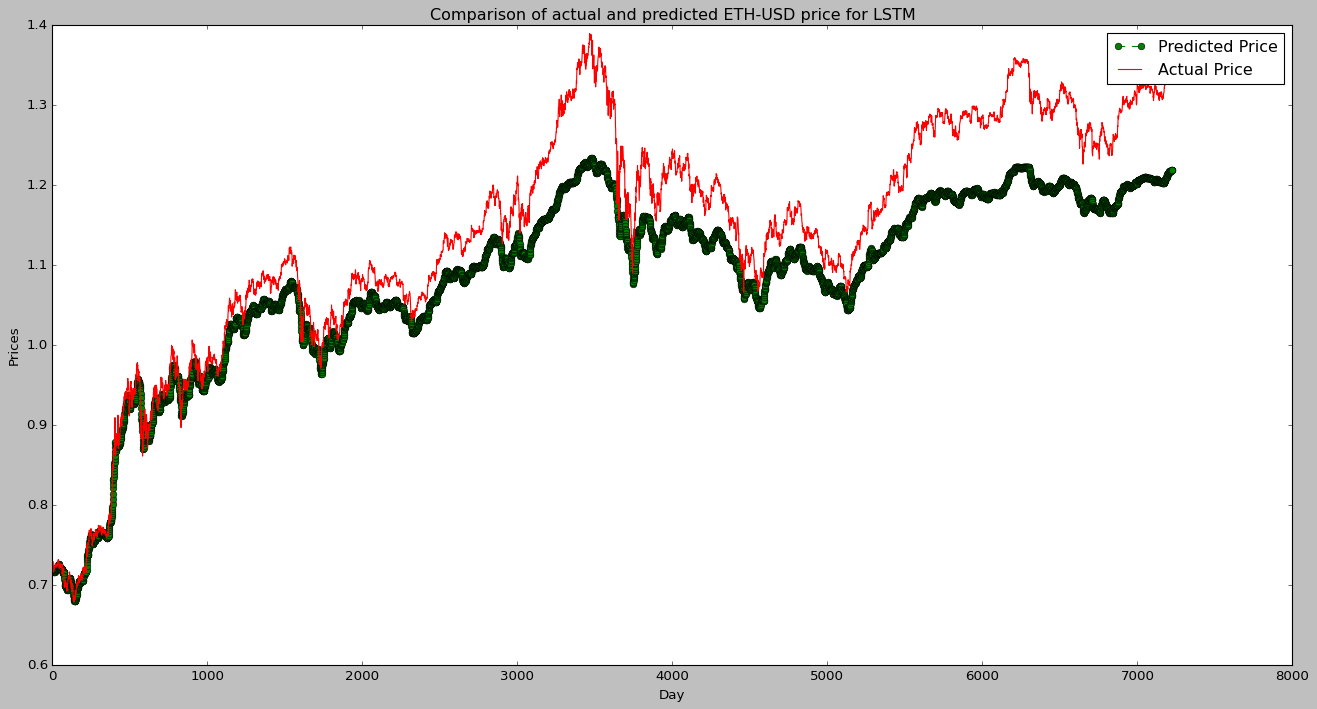

(0.8023358259283299, 0.05617910554692762)

In [160]:
# Evaluate the model and plot the results
evaluate_model(LSTM_Model, "LSTM")

## **8.3 CNN**

In [147]:
# Instantiate sequential model
CNN_model=Sequential()

In [148]:
# Define cnn model
CNN_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=X_train[0].shape))
CNN_model.add(MaxPooling1D(3))
CNN_model.add(Dropout(0.1))
CNN_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
CNN_model.add(MaxPooling1D(3))
CNN_model.add(Dropout(0.1))
CNN_model.add(Flatten())
CNN_model.add(Dense(32, activation='relu'))
CNN_model.add(Dense(1, activation='relu'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [149]:
# Config the model
CNN_model.compile(optimizer='adam', loss='mse')

In [150]:
# Summary of model
CNN_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 48, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 16, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 14, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,593 (57.00 KB)

 Trainable params: 14,593 (57.00 KB)

 Non-trainable params: 0 (0.00 B)

In [151]:
# Fit the model
CNN_model.fit(X_train, y_train, epochs=20, validation_split=0.1)

Epoch 1/20


KeyboardInterrupt: 

In [ ]:
# Evaluate the model and plot the results
evaluate_model(CNN_model, "CNN")

In [159]:
#Save models
LSTM_Model.save('LSTM.keras')
CNN_model.save('CNN.keras')

# **9. Deploy Model into Recent Data**

In [152]:
# Reminder on recent data which contains three months of eth price
eth_recent.head()

,open,high,low,close,Volume ETH,Volume USDT,close_log
date,,,,,,,
2021-10-16 00:00:00,3868.38,3872.98,3838.98,3844.83,11349.8454,4.375050e+07,8.254745
2021-10-16 01:00:00,3844.84,3854.95,3823.04,3836.19,10986.7950,4.217460e+07,8.252496
2021-10-16 02:00:00,3836.18,3854.78,3823.81,3853.31,11101.0012,4.260368e+07,8.256947
2021-10-16 03:00:00,3853.31,3853.31,3833.00,3842.95,7793.7926,2.996249e+07,8.254256
2021-10-16 04:00:00,3842.95,3867.82,3834.66,3834.66,12265.4954,4.720833e+07,8.252097


In [153]:
# Scale before model
scaled_recent = scaler.fit_transform(eth_recent)

In [154]:
# Generate a new dataset out of recent data
X_test2, y_test2 = create_dataset(scaled_recent, 50, -1)

In [206]:
# Check the shape
X_test2.shape

# X_test2_df = pd.DataFrame(X_test2.reshape(X_test2.shape[0], X_test2.shape[1]))
# X_test2_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.862032,0.860692,0.863345,0.861741,0.860454,0.863757,0.862539,0.863408,0.876695,0.875793,...,0.856937,0.855778,0.856795,0.849746,0.838904,0.849521,0.859180,0.862345,0.866875,0.866678
1,0.860692,0.863345,0.861741,0.860454,0.863757,0.862539,0.863408,0.876695,0.875793,0.876268,...,0.855778,0.856795,0.849746,0.838904,0.849521,0.859180,0.862345,0.866875,0.866678,0.864597
2,0.863345,0.861741,0.860454,0.863757,0.862539,0.863408,0.876695,0.875793,0.876268,0.879127,...,0.856795,0.849746,0.838904,0.849521,0.859180,0.862345,0.866875,0.866678,0.864597,0.863261
3,0.861741,0.860454,0.863757,0.862539,0.863408,0.876695,0.875793,0.876268,0.879127,0.870045,...,0.849746,0.838904,0.849521,0.859180,0.862345,0.866875,0.866678,0.864597,0.863261,0.865259
4,0.860454,0.863757,0.862539,0.863408,0.876695,0.875793,0.876268,0.879127,0.870045,0.873436,...,0.838904,0.849521,0.859180,0.862345,0.866875,0.866678,0.864597,0.863261,0.865259,0.866807


911/911 ━━━━━━━━━━━━━━━━━━━━ 54s 58ms/step
R Squared :  0.99855
Mean Absolute Error:  0.00635


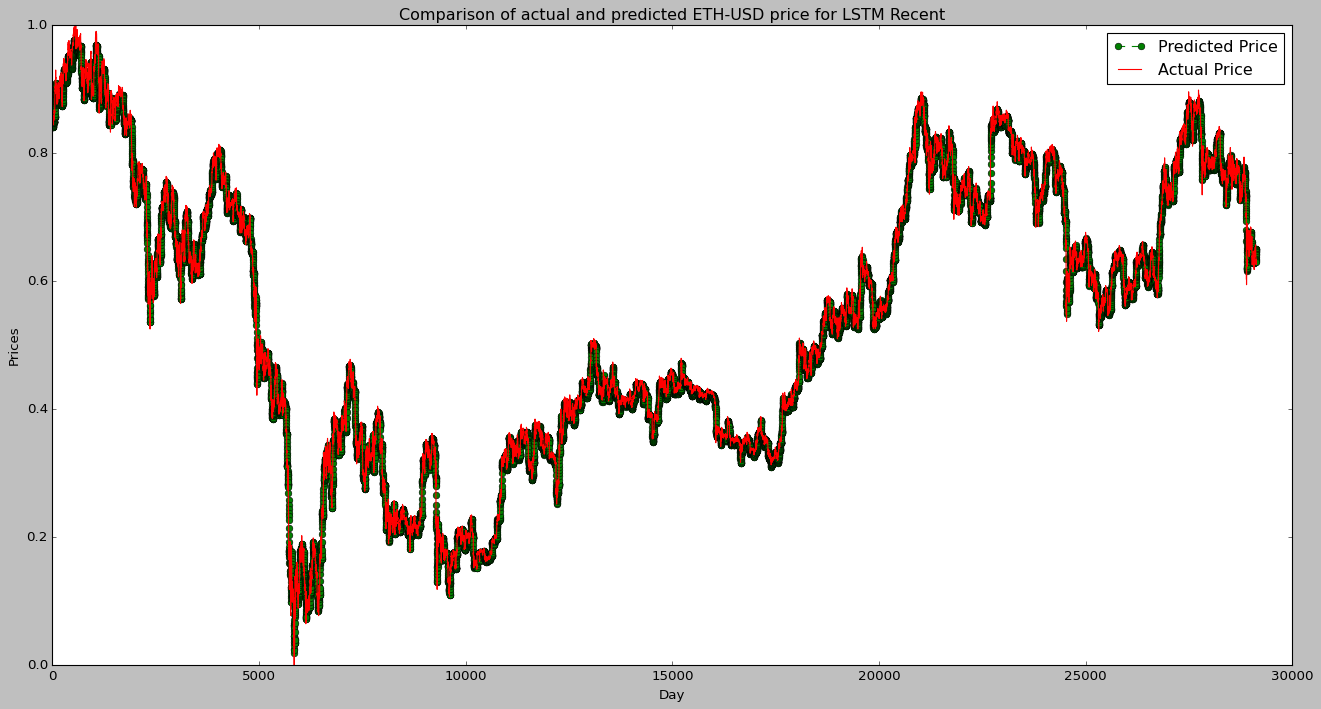

(0.9985484058618239, 0.006345811012079026)

In [156]:
# Evaluate the performance of model on recent data and plot the results
evaluate_model(LSTM_Model, "LSTM Recent", X_test2, y_test2)

# **10. Conclusions**

In [ ]:
result = {'Model': ['XGBOOST', 'LSTM', 'CNN'],
          'R-squared': [-0.247, 0.942, 0.704], 'MAE':[0.169, 0.034, 0.096]}

In [ ]:
df_result = pd.DataFrame(result)
df_result.set_index('Model', inplace=True)
df_result

### **11. Prediction Set**

In [263]:
# Create prediction set

# 4. Create future dates for prediction
last_date = eth.index[-1]
t = 24*7+1
future_dates = [last_date + timedelta(hours=i) for i in range(1, t)]  # 3 years *365*3

# 5. Prepare input data for future prediction

look_back = 48
future_input = eth.index[-look_back:] # Last 'look_back' data points
# Convert DatetimeIndex to numpy array before reshaping
future_input = eth['close'].tail(look_back).values.reshape(1, look_back, 1)

print(future_dates)

future_values = np.zeros(168)

print(future_values)

# print(future_input[:, -5:, :])

# evaluate_model(LSTM_Model, "LSTM Recent", X_test2, y_test2)

[Timestamp('2025-02-12 00:00:00'), Timestamp('2025-02-12 01:00:00'), Timestamp('2025-02-12 02:00:00'), Timestamp('2025-02-12 03:00:00'), Timestamp('2025-02-12 04:00:00'), Timestamp('2025-02-12 05:00:00'), Timestamp('2025-02-12 06:00:00'), Timestamp('2025-02-12 07:00:00'), Timestamp('2025-02-12 08:00:00'), Timestamp('2025-02-12 09:00:00'), Timestamp('2025-02-12 10:00:00'), Timestamp('2025-02-12 11:00:00'), Timestamp('2025-02-12 12:00:00'), Timestamp('2025-02-12 13:00:00'), Timestamp('2025-02-12 14:00:00'), Timestamp('2025-02-12 15:00:00'), Timestamp('2025-02-12 16:00:00'), Timestamp('2025-02-12 17:00:00'), Timestamp('2025-02-12 18:00:00'), Timestamp('2025-02-12 19:00:00'), Timestamp('2025-02-12 20:00:00'), Timestamp('2025-02-12 21:00:00'), Timestamp('2025-02-12 22:00:00'), Timestamp('2025-02-12 23:00:00'), Timestamp('2025-02-13 00:00:00'), Timestamp('2025-02-13 01:00:00'), Timestamp('2025-02-13 02:00:00'), Timestamp('2025-02-13 03:00:00'), Timestamp('2025-02-13 04:00:00'), Timestamp('20

In [233]:

# print(last_date)

# Convert the list to a pandas Series before using tail
future_dates_series = pd.Series(future_dates)
#future_dates_series.tail(5)
#future_dates_series.head(5)

future_input_series = pd.Series(future_input.flatten())

#future_input_series.tail(5)
future_input_series.head(50)

,0
0,2642.71
1,2574.69
2,2589.54
3,2625.97
4,2628.75
5,2638.40
6,2636.25
7,2637.03
8,2644.80
9,2650.40


In [234]:
future_dates_series.head(5)

,0
0,2025-02-12 00:00:00
1,2025-02-12 01:00:00
2,2025-02-12 02:00:00
3,2025-02-12 03:00:00
4,2025-02-12 04:00:00


In [264]:
# Generate predictions for the entire future time set (future_dates)
num_predictions = len(future_dates)  # Number of predictions needed

print(num_predictions)

future_predictions = []  # Initialize an empty list to store predictions

print(future_predictions)


168
[]


In [284]:
nan = eth[eth.isnull().any(axis=1)]

nan2 = future_dates

# nan[0, :] = nan2

eth_columns = eth.columns

nan2_reshaped = [[date] + [np.nan] * (len(eth_columns) - 1) for date in nan2]

new_row = pd.DataFrame(nan2_reshaped, columns=eth_columns)

# If 'nan' is empty, simply assign 'new_row' to 'nan'
if nan.empty:
    nan = new_row
else:
    # If 'nan' is not empty, append the new row
    nan = pd.concat([nan, new_row], ignore_index=True)

    nan = nan.rename(columns={nan.columns[1]: 'date'})

nan
#nan2

,open,high,low,close,Volume ETH,Volume USDT,close_log
0,2025-02-12 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-02-12 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-02-12 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-02-12 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-02-12 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
163,2025-02-18 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN
164,2025-02-18 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN
165,2025-02-18 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN
166,2025-02-18 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:


# Instead of modifying future_input directly, create a copy for predictions
future_input_for_pred = future_input.copy()

for _ in range(num_predictions):
    # Use the numerical copy for prediction
    prediction = model.predict(future_input_for_pred)
    future_predictions.append(prediction[0, 0])

    # Create a new row with the prediction and move the prediction window forward
    new_row = np.array([[prediction[0, 0]]])  # Create new row with prediction
    new_row = new_row.reshape(1, 1, 1)  # Reshape for concatenation

    # Shift the numerical input data and add the new prediction
    future_input_for_pred = np.concatenate([future_input_for_pred[:, 1:, :], new_row], axis=1)

# Create the DataFrame using future_dates as the index
future_predictions_df = pd.DataFrame({'Predictions': future_predictions}, index=future_dates)
future_predictions_df.index.name = 'Date'

print(future_predictions_df)

In [248]:
print(future_predictions_df.loc[future_dates_series.tail(100).values])

                     Predictions
Date                            
2025-02-14 20:00:00     1.032986
2025-02-14 21:00:00     1.029109
2025-02-14 22:00:00     1.025315
2025-02-14 23:00:00     1.021603
2025-02-15 00:00:00     1.017970
...                          ...
2025-02-18 19:00:00     0.838993
2025-02-18 20:00:00     0.837805
2025-02-18 21:00:00     0.836625
2025-02-18 22:00:00     0.835454
2025-02-18 23:00:00     0.834289

[100 rows x 1 columns]


In [258]:

# Import the LabelEncoder class from the sklearn.preprocessing module
from sklearn.preprocessing import LabelEncoder

# Assuming 'future_dates_series' is a Pandas Series of datetime objects
# Convert 'future_dates_series' to numerical representation using LabelEncoder
label_encoder = LabelEncoder()
X_train_encoded = label_encoder.fit_transform(future_dates_series)

# Create DataFrames with the encoded values
X_train = pd.DataFrame(X_train_encoded, columns=['Date'])
y_train = pd.DataFrame(X_train_encoded, columns=['Predictions'])  # Assuming you want to predict the date itself

# Now you can fit the model
LSTM_Model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.05)

LSTM_Model.fit(X_train,y_train,batch_size=32,epochs=10,verbose=1,validation_split=0.05)

evaluate_model(LSTM_Model, "LSTM",X_train,y_train)



Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 2217.7817 - val_loss: 11104.4727
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2405.1128 - val_loss: 10973.7666
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2078.3943 - val_loss: 10847.8711
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1982.8759 - val_loss: 10725.4258
Epoch 5/10
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 1609.6013

KeyboardInterrupt: 

In [190]:
# 6. Make future predictions
future_predictions = []

model = LSTM_Model

# Convert future_input to float32 initially (for ordinal representation)
future_input = future_input.astype(np.float32)

for _ in range(168):  # Predicting for a week, hourly

#for _ in range(24*365*3):  # Predicting for 3 years, hourly

    # Predict using the current future_input
    prediction = model.predict(future_input)
    future_predictions.append(prediction[0, 0])

    # Create a new row with the prediction and the next hour
    last_datetime_ordinal = future_input[0, -1, 0]
    next_datetime_ordinal = last_datetime_ordinal + 1/24.0  # Assuming ordinal representation; adding 1/24 for hourly step
    new_row = np.array([[next_datetime_ordinal, prediction[0, 0]]])

    # Reshape new_row for concatenation
    new_row = new_row.reshape(1, 1, 2)

    # Concatenate to future_input, removing the oldest data point
    future_input = np.concatenate([future_input[:, 1:, :], new_row[:, :, 1:]], axis=1)

# Instead of converting back to datetimes using fromordinal,
# use the original future_dates list which contains the correct DatetimeIndex values.
future_predictions_df = pd.DataFrame({'Predictions': future_predictions}, index=future_dates[-len(future_predictions):])
future_predictions_df.index.name = 'Date'

print(future_predictions_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
                     Predictions
Date                            
2028-02-11 

In [229]:
evaluate_model(LSTM_Model, "LSTM Recent", future_input, future_predictions_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


ValueError: Found input variables with inconsistent numbers of samples: [24, 1]

In [ ]:
# 6. Make future predictions
future_predictions = []
for _ in range(365*3):
    prediction = model.predict(future_input)
    future_predictions.append(prediction[0, 0])
    future_input = np.append(future_input[:, 1:, :], prediction.reshape(1, 1, 1), axis=1) # Update input for next step

# Invert future predictions to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# 7. Create a DataFrame for future predictions
future_df = pd.DataFrame({'date': future_dates, 'predicted_price': future_predictions.flatten()})
future_df.set_index('date', inplace=True)

# 8. Concatenate original data with predictions
eth_with_predictions = pd.concat([eth, future_df])

# 9. Plot the results
plt.plot(eth_with_predictions['price'], label='Actual Price')
plt.plot(future_df['predicted_price'], label='Predicted Price')
plt.legend()
plt.title('Ethereum Price Prediction for Next 3 Years (LSTM)')
plt.show()